In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import os
import torch

d:\conda_envs\tinyllama\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
CSV_PATH = r"D:\Qwen2.5-0.5B-BN\BengaliEmpatheticConversationsCorpus.csv"
OUT_DIR2 = "./qwen2.5-0.5B-bangla-4col-ft"
os.makedirs(OUT_DIR2, exist_ok=True)

print("CUDA:", torch.cuda.is_available(), torch.cuda.get_device_name(0))
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

for col in ["Topics", "Question-Title", "Questions", "Answers"]:
    df[col] = df[col].replace(["null", "NULL", "Null", "NaN"], np.nan)

df = df.dropna(subset=["Topics", "Question-Title", "Questions", "Answers"]).reset_index(drop=True)

print("Clean rows:", len(df))

CUDA: True NVIDIA GeForce RTX 3060
Clean rows: 37610


In [3]:
def make_chat_text(r):
    t = str(r["Topics"]).strip()
    title = str(r["Question-Title"]).strip()
    q = str(r["Questions"]).strip()
    a = str(r["Answers"]).strip()

    system_prompt = "You are a kind, empathetic Bangla mental health assistant."

    return (
        f"<|system|>\n{system_prompt}\n"
        f"<|user|>\n[বিষয়: {t} | শিরোনাম: {title}]\n{q}\n"
        f"<|assistant|>\n{a}"
    )

df["text"] = df.apply(make_chat_text, axis=1)
df = df[["text"]].sample(frac=1, random_state=42).reset_index(drop=True)
df.head(3)


,text
0,"<|system|>\nYou are a kind, empathetic Bangla ..."
1,"<|system|>\nYou are a kind, empathetic Bangla ..."
2,"<|system|>\nYou are a kind, empathetic Bangla ..."


In [4]:
from datasets import Dataset

hf_ds = Dataset.from_pandas(df)
TOTAL = len(hf_ds)

TRAIN_SIZE = 27610
TEST_SIZE = 10000

train_ds = hf_ds.select(range(TRAIN_SIZE))
test_ds = hf_ds.select(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))

train_df = train_ds.to_pandas()
test_df = test_ds.to_pandas()

train_df.to_csv("BanglaMH_train_28k_qwen.csv", index=False, encoding="utf-8")
test_df.to_csv("BanglaMH_test_10k_qwen.csv", index=False, encoding="utf-8")

print("Saved split CSVs.")


Saved split CSVs.


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True
)
print("Model and tokenizer loaded for evaluation!")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Model and tokenizer loaded for evaluation!


In [3]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 8,798,208 || all params: 502,830,976 || trainable%: 1.7497


In [7]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_tokenized = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
test_tokenized = test_ds.map(tokenize_fn, batched=True, remove_columns=["text"])


Map:   0%|          | 0/27610 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUT_DIR2,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    fp16=True,
    logging_steps=100,
    save_steps=5000,
    save_total_limit=2,
    do_eval=True,
    report_to=[],
    dataloader_num_workers=2
)


In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)

C:\Users\Sadman Sakib\AppData\Local\Temp\ipykernel_29248\2331645801.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
100,1.131600
200,0.923400
300,0.893300
400,0.866100
500,0.846100
600,0.832800
700,0.832500
800,0.828400
900,0.816000
1000,0.799200


TrainOutput(global_step=6904, training_loss=0.7537899617869774, metrics={'train_runtime': 11861.7979, 'train_samples_per_second': 4.655, 'train_steps_per_second': 0.582, 'total_flos': 6.22048382681088e+16, 'train_loss': 0.7537899617869774, 'epoch': 2.0})

In [12]:
model.save_pretrained(OUT_DIR2)
tokenizer.save_pretrained(OUT_DIR2)

print("Model saved at:", OUT_DIR2)


Model saved at: ./qwen2.5-0.5B-bangla-4col-ft


In [13]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=OUT_DIR2,
    tokenizer=OUT_DIR2,
    device_map="auto"
)

system_prompt = "You are a kind, empathetic Bangla mental health assistant."

test_prompts = [
    "আমি চাকরি হারিয়েছি, খুব হতাশ বোধ করছি। আমি কী করব?",
    "আমার পরিবার আমার সিদ্ধান্তকে সমর্থন করছে না। কীভাবে সামলাব?",
    "বন্ধুর আচরণ হঠাৎ বদলে গেছে, মনে হয় মানসিক সমস্যা হচ্ছে। কী করব?"
]

for p in test_prompts:
    prompt = (
        f"<|system|>\n{system_prompt}\n"
        f"<|user|>\n{p}\n"
        f"<|assistant|>\n"
    )

    out = pipe(
        prompt,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.05
    )

    print("\nUser:", p)
    print("Assistant:", out[0]["generated_text"].split("<|assistant|>")[-1].strip())


Device set to use cuda:0



User: আমি চাকরি হারিয়েছি, খুব হতাশ বোধ করছি। আমি কী করব?
Assistant: এটা মজা! তারা একটি ভাল পুরানো স্থান ছিল. তারা খুব গাড়ি কাটাচ্ছিলে এবং অন্যদের সাথে সহজেই এসেছিল। তাদের জন্য আপনার কাছে কি আছে? আপনার কাছে তারা ক

User: আমার পরিবার আমার সিদ্ধান্তকে সমর্থন করছে না। কীভাবে সামলাব?
Assistant: তারা একজন অস্বস্তি যা আপনাকে উত্তেজিত করে, তারা যখন অনুস্মারণ করে তখন অনুপ্রেরণা হয়ে যায়। তারা এই সময়ের জন্য সামলাইট বা অনুভব করে। আপনি কি অন

User: বন্ধুর আচরণ হঠাৎ বদলে গেছে, মনে হয় মানসিক সমস্যা হচ্ছে। কী করব?
Assistant: কেউ পরিবর্তন হতে দেখায় এবং আপনি শিশুদের জন্য অনেক সময় পরিবর্তন করেন। আপনি এই মহিলার সাথে বাড়ি চলে গেছেন এবং আপনার ভাল কাজ করেন। আপনার পরিবার �


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import torch
import evaluate
from tqdm import tqdm

In [5]:
model_path = r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft"
test_path  = r"D:\Qwen2.5-0.5B-BN\BanglaMH_test_10k_qwen.csv"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

model.to(device)
model.eval()

`torch_dtype` is deprecated! Use `dtype` instead!


CUDA: True
GPU: NVIDIA GeForce RTX 3060


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=896, out_features=896, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=896, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=896, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=896, out_features=128, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropou

In [17]:
df_test = pd.read_csv(test_path)
print("Rows:", len(df_test))


Rows: 10000


In [18]:
def extract_user_and_ref(text):
    try:
        user = text.split("<|user|>")[1].split("<|assistant|>")[0].strip()
        ref  = text.split("<|assistant|>")[1].strip()
        return user, ref
    except:
        return None, None

inputs = []
references = []

for row in df_test["text"]:
    u, r = extract_user_and_ref(row)
    if u is not None:
        inputs.append(u)
        references.append(r)

print("Valid Pairs:", len(inputs))


Valid Pairs: 10000


In [19]:
predictions = []
batch_size = 16
max_new_tokens = 64

system_prompt = "You are a kind, empathetic Bangla mental health assistant."

for i in tqdm(range(0, len(inputs), batch_size)):
    batch_users = inputs[i:i+batch_size]

    # build Qwen-style prompts
    batch_prompts = [
        f"<|system|>\n{system_prompt}\n<|user|>\n{u}\n<|assistant|>\n"
        for u in batch_users
    ]

    tokens = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    outputs = model.generate(
        **tokens,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for out in decoded:
        if "<|assistant|>" in out:
            gen = out.split("<|assistant|>")[-1].strip()
        else:
            gen = out.strip()
        predictions.append(gen)

print("Generation finished.")


100%|██████████| 625/625 [50:03<00:00,  4.81s/it]

Generation finished.


In [21]:
df_test["Qwen_pred"] = predictions
df_test.to_csv("qwen0.5_predictions.csv", index=False)
print("Saved: qwen0.5_predictions.csv")


Saved: qwen0.5_predictions.csv


In [22]:
def extract_answer(full_text):
    return full_text.split("<|assistant|>")[-1].strip()

df_test["reference"] = df_test["text"].apply(extract_answer)
references = df_test["reference"].tolist()
predictions = df_test["Qwen_pred"].tolist()


In [23]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to C:\Users\Sadman
[nltk_data]     Sakib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Sadman
[nltk_data]     Sakib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
import sacrebleu
from bert_score import score as bert_score

# ROUGE
rouge = evaluate.load("rouge")
results_rouge = rouge.compute(predictions=predictions, references=references)

# BLEU
results_bleu = sacrebleu.corpus_bleu(predictions, [references]).score

# BERTScore
P, R, F1 = bert_score(predictions, references, lang="bn")

print("===== ROUGE =====")
print(results_rouge)

print("\n===== BLEU =====")
print(results_bleu)

print("\n===== BERTScore =====")
print("Precision:", float(P.mean()))
print("Recall:", float(R.mean()))
print("F1:", float(F1.mean()))


===== ROUGE =====
{'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}

===== BLEU =====
0.5961047880151615

===== BERTScore =====
Precision: 0.6902719736099243
Recall: 0.6935785412788391
F1: 0.6912808418273926


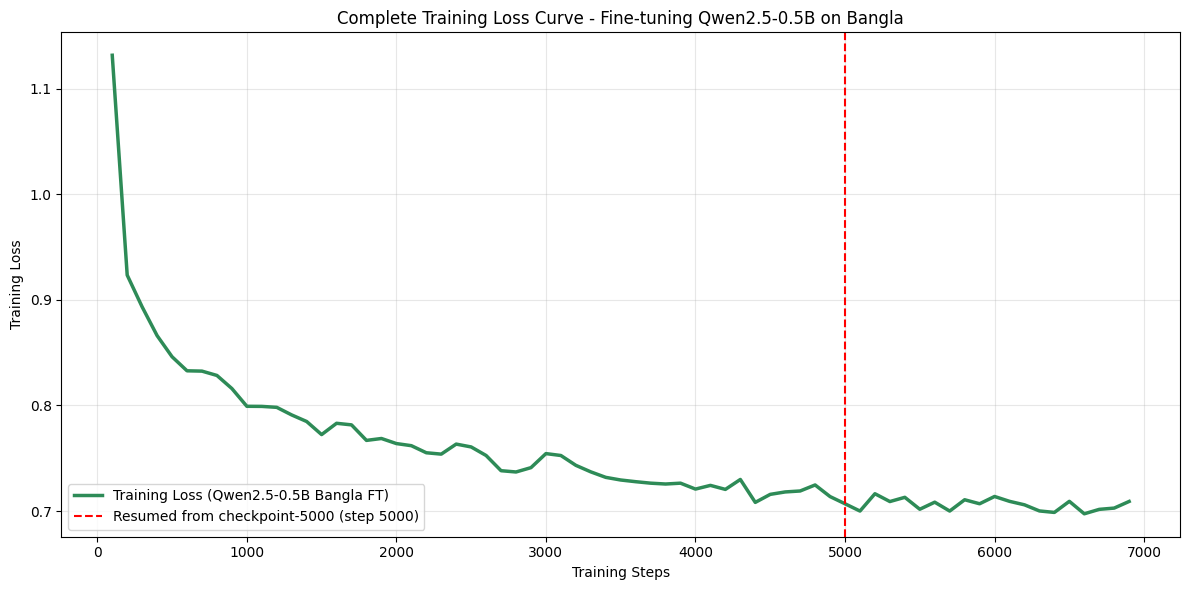

Total steps plotted: 69
Steps from checkpoint-5000: 50
Additional steps from checkpoint-6904: 19
Final loss: 0.7091


In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt

files = {
    "checkpoint-5000": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

# Load and properly convert log_history → DataFrame
def load_log_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # log_history is a list of dicts → convert directly to DataFrame
    df = pd.DataFrame(data["log_history"])
    return df

df1 = load_log_history(files["checkpoint-5000"])
df2 = load_log_history(files["checkpoint-6904"])

# Keep only rows that have training loss
df1 = df1[df1["loss"].notna()].copy()
df2 = df2[df2["loss"].notna()].copy()

# Find where to continue: after the last step of checkpoint-5000
last_step_ckpt5000 = df1["step"].max()

# Combine: full ckpt-5000 + only new steps from ckpt-6904
new_part = df2[df2["step"] > last_step_ckpt5000]
df_combined = pd.concat([df1, new_part], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined["step"], df_combined["loss"], 
         label="Training Loss (Qwen2.5-0.5B Bangla FT)", 
         linewidth=2.5, color="#2E8B57")

# Mark resume point
plt.axvline(x=last_step_ckpt5000, color="red", linestyle="--", linewidth=1.5,
            label=f"Resumed from checkpoint-5000 (step {int(last_step_ckpt5000)})")

plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Complete Training Loss Curve - Fine-tuning Qwen2.5-0.5B on Bangla")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print some stats
print(f"Total steps plotted: {len(df_combined)}")
print(f"Steps from checkpoint-5000: {len(df1)}")
print(f"Additional steps from checkpoint-6904: {len(new_part)}")
print(f"Final loss: {df_combined['loss'].iloc[-1]:.4f}")

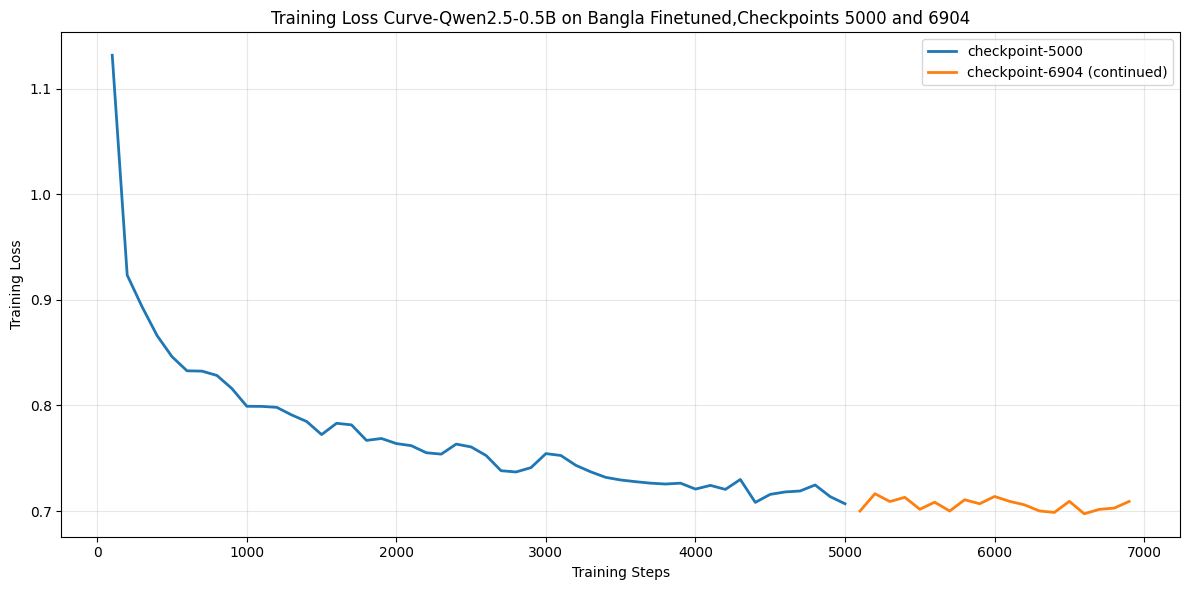

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

files = {
    "checkpoint-5000": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904 (continued)": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

plt.figure(figsize=(12, 6))

for label, f in files.items():
    with open(f, "r", encoding="utf-8") as j:
        data = json.load(j)
        df = pd.DataFrame(data["log_history"])
        df = df[df["loss"].notna()].copy()  # only training loss rows

    # For checkpoint-6904, only plot steps > 5000 to avoid overlap
    if "6904" in label:
        df = df[df["step"] > 5000]

    plt.plot(df["step"], df["loss"], label=label, linewidth=2)

# Formatting
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve-Qwen2.5-0.5B on Bangla Finetuned,Checkpoints 5000 and 6904")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

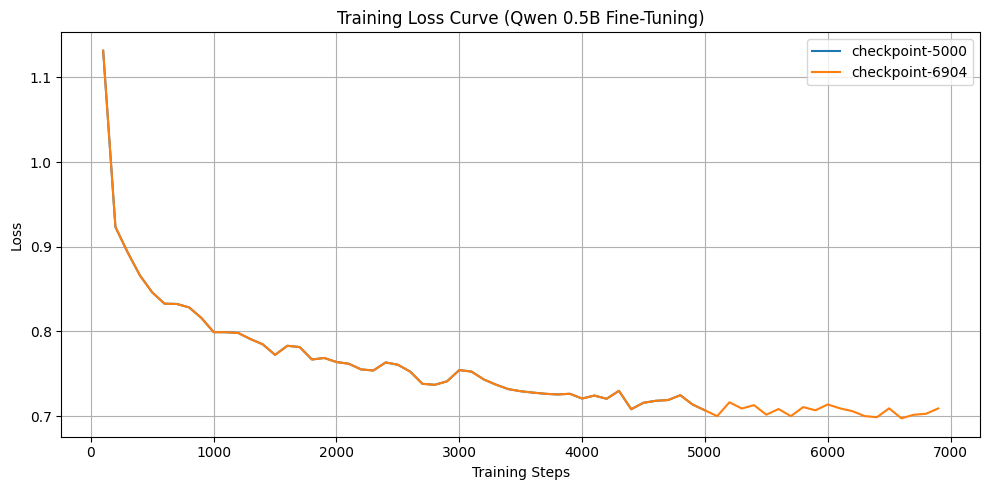

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Paths to trainer_state.json with labels
files = {
    "checkpoint-5000": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

plt.figure(figsize=(10,5))

for label, f in files.items():
    with open(f, "r") as j:
        data = json.load(j)
        df = pd.DataFrame(data["log_history"])
        df = df[df["loss"].notna()]  # only rows with training loss

    plt.plot(df["step"], df["loss"], label=label)  # different color automatically

# Formatting
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Qwen 0.5B Fine-Tuning)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd

def extract_parts(text):
    try:
        system = text.split("<|system|>")[1].split("<|user|>")[0].strip()
        user   = text.split("<|user|>")[1].split("<|assistant|>")[0].strip()
        answer = text.split("<|assistant|>")[1].strip()

        return system, user, answer
    except:
        return None, None, None

df = pd.read_csv("qwen0.5_predictions.csv")

systems = []
questions = []
expected_answers = []

for t in df["text"]:
    s, q, a = extract_parts(t)
    systems.append(s)
    questions.append(q)
    expected_answers.append(a)

df["System"] = systems
df["Question"] = questions
df["Expected_Answer"] = expected_answers
df["LLM_Response"] = df["Qwen_pred"]


In [19]:
import sacrebleu
from bert_score import score as bert_score

references = df["Expected_Answer"].tolist()
preds      = df["LLM_Response"].tolist()

# BLEU
bleu_scores = []
for p, r in zip(preds, references):
    bleu_scores.append(sacrebleu.corpus_bleu([p], [[r]]).score)

df["BLEU"] = bleu_scores

# BERTScore
P, R, F1 = bert_score(preds, references, lang="bn")

df["BERT_P"] = P
df["BERT_R"] = R
df["BERT_F1"] = F1

df.to_csv("BanglaMH_Evaluation_Final.csv", index=False, encoding="utf-8")


In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

device = "cuda"

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16
).to(device)

batch_size = 16
max_new_tokens = 80

system_prompt = systems[0]  # already parsed earlier

zero_shot_preds = []

for i in tqdm(range(0, len(questions), batch_size)):

    batch_q = questions[i:i+batch_size]

    # Build prompts for ALL 16 at once
    batch_prompts = [
        f"<|system|>\n{system_prompt}\n<|user|>\n{q}\n<|assistant|>\n"
        for q in batch_q
    ]

    tokens = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **tokens,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for txt in decoded:
        if "<|assistant|>" in txt:
            reply = txt.split("<|assistant|>")[-1].strip()
        else:
            reply = txt.strip()

        zero_shot_preds.append(reply)

df["ZeroShot_Response"] = zero_shot_preds


`torch_dtype` is deprecated! Use `dtype` instead!
  0%|          | 0/625 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
100%|██████████| 625/625 [39:43<00:00,  3.81s/it]


In [22]:
zs_refs = df["Expected_Answer"].tolist()
zs_preds = df["ZeroShot_Response"].tolist()

# BLEU
zs_bleu_scores = []
for p, r in zip(zs_preds, zs_refs):
    zs_bleu_scores.append(sacrebleu.corpus_bleu([p], [[r]]).score)

df["ZeroShot_BLEU"] = zs_bleu_scores

# BERTScore
Pz, Rz, F1z = bert_score(zs_preds, zs_refs, lang="bn")
df["ZeroShot_BERT_P"] = Pz
df["ZeroShot_BERT_R"] = Rz
df["ZeroShot_BERT_F1"] = F1z


In [23]:
df.to_csv("BanglaMH_ZeroShot_vs_Finetuned.csv", index=False)


In [25]:
import pandas as pd
import sacrebleu
from bert_score import score as bert_score
import numpy as np

# Load data
df = pd.read_csv("BanglaMH_ZeroShot_vs_Finetuned.csv")

# Extract columns
refs = df["Expected_Answer"].tolist()
pred_ft = df["LLM_Response"].tolist()
pred_zs = df["ZeroShot_Response"].tolist()

# ==========================
# Clean predictions: replace NaN/None/empty with "<empty>"
# ==========================
def clean_predictions(preds):
    return [
        "<empty>" if pd.isna(x) or str(x).strip() == "" else str(x).strip()
        for x in preds
    ]

# Also clean references (just in case)
refs = clean_predictions(df["Expected_Answer"])
pred_ft = clean_predictions(pred_ft)
pred_zs = clean_predictions(pred_zs)

# -------------------------
# Helper: compute metrics (safe)
# -------------------------
def compute_metrics(preds, refs):
    # BLEU
    bleu = sacrebleu.corpus_bleu(preds, [refs]).score

    # BERTScore (handles empty strings safely)
    P, R, F1 = bert_score(preds, refs, lang="bn", verbose=False)
    
    return bleu, float(P.mean()), float(R.mean()), float(F1.mean())

# ==========================
# Fine-Tuned Model Metrics
# ==========================
ft_bleu, ft_p, ft_r, ft_f1 = compute_metrics(pred_ft, refs)

print("\n===== FINE-TUNED MODEL =====")
print(f"BLEU:          {ft_bleu:.4f}")
print(f"BERT Precision: {ft_p:.4f}")
print(f"BERT Recall:    {ft_r:.4f}")
print(f"BERT F1:        {ft_f1:.4f}")

# ==========================
# Zero-Shot Base Model Metrics
# ==========================
zs_bleu, zs_p, zs_r, zs_f1 = compute_metrics(pred_zs, refs)

print("\n===== ZERO-SHOT MODEL =====")
print(f"BLEU:          {zs_bleu:.4f}")
print(f"BERT Precision: {zs_p:.4f}")
print(f"BERT Recall:    {zs_r:.4f}")
print(f"BERT F1:        {zs_f1:.4f}")

# Optional: Show how many generations were empty/missing
n_empty_ft = sum(1 for x in df["LLM_Response"] if pd.isna(x) or str(x).strip() == "")
n_empty_zs = sum(1 for x in df["ZeroShot_Response"] if pd.isna(x) or str(x).strip() == "")

print(f"\nWarning: Empty/NaN responses replaced with '<empty>':")
print(f"  Fine-tuned model:  {n_empty_ft} cases")
print(f"  Zero-shot model:   {n_empty_zs} cases")


===== FINE-TUNED MODEL =====
BLEU:          0.5961
BERT Precision: 0.6903
BERT Recall:    0.6936
BERT F1:        0.6913

===== ZERO-SHOT MODEL =====
BLEU:          0.0525
BERT Precision: 0.6003
BERT Recall:    0.6347
BERT F1:        0.6160

  Fine-tuned model:  0 cases
  Zero-shot model:   4 cases


In [1]:
import json
import pandas as pd

files = {
    "checkpoint-5000": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

all_logs = []

for label, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Extract log_history and add a column to know which checkpoint it came from
    df = pd.DataFrame(data["log_history"])
    df["source_checkpoint"] = label.split(" (")[0]  # clean name: checkpoint-5000 or checkpoint-6904
    
    # Only keep rows that have training loss
    df = df[df["loss"].notna()].copy()
    
    all_logs.append(df)

# Combine everything
combined_df = pd.concat(all_logs, ignore_index=True)

# Sort by step (important when training was continued)
combined_df = combined_df.sort_values("step").reset_index(drop=True)

# Save to CSV
output_csv = r"D:\Qwen2.5-0.5B-BN\training_loss_combined.csv"
combined_df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"Combined CSV saved to: {output_csv}")
print(f"Total rows: {len(combined_df)}")
print(combined_df[["step", "loss", "epoch", "learning_rate", "source_checkpoint"]].tail(10))

Combined CSV saved to: D:\Qwen2.5-0.5B-BN\training_loss_combined.csv
Total rows: 119
     step    loss     epoch  learning_rate source_checkpoint
109  6000  0.7138  1.738283   2.621669e-06   checkpoint-6904
110  6100  0.7092  1.767258   2.331981e-06   checkpoint-6904
111  6200  0.7059  1.796233   2.042294e-06   checkpoint-6904
112  6300  0.7001  1.825208   1.752607e-06   checkpoint-6904
113  6400  0.6987  1.854183   1.462920e-06   checkpoint-6904
114  6500  0.7092  1.883158   1.173233e-06   checkpoint-6904
115  6600  0.6974  1.912133   8.835458e-07   checkpoint-6904
116  6700  0.7016  1.941108   5.938586e-07   checkpoint-6904
117  6800  0.7028  1.970083   3.041715e-07   checkpoint-6904
118  6900  0.7091  1.999058   1.448436e-08   checkpoint-6904


In [2]:
import json
import pandas as pd

files = {
    "checkpoint-5000": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904": r"D:\Qwen2.5-0.5B-BN\qwen2.5-0.5B-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

for label, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    df = pd.DataFrame(data["log_history"])
    df = df[df["loss"].notna()].copy()  # keep only training loss rows
    
    # Optional: add source column
    df["source"] = label.split(" (")[0]
    
    output_csv = fr"D:\Qwen2.5-0.5B-BN\training_loss_{label.split(' (')[0]}.csv"
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"Saved {len(df)} rows → {output_csv}")

Saved 50 rows → D:\Qwen2.5-0.5B-BN\training_loss_checkpoint-5000.csv
Saved 69 rows → D:\Qwen2.5-0.5B-BN\training_loss_checkpoint-6904.csv


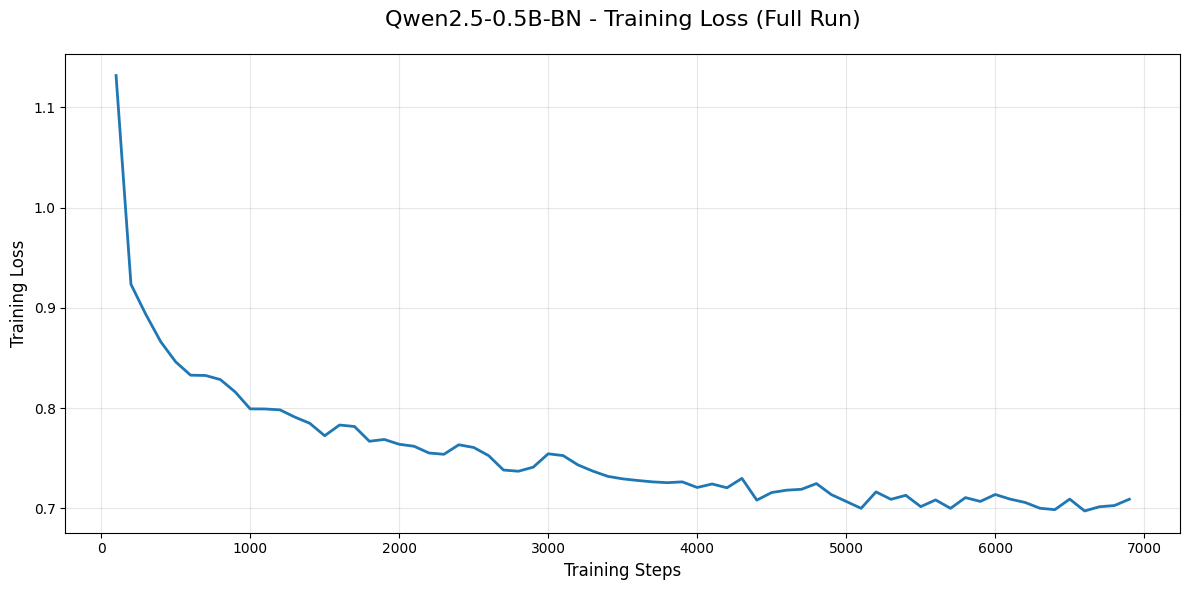

Total logged steps: 119
Initial loss : 1.1316
Final loss   : 0.7091


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined CSV we created earlier
csv_path = r"D:\Qwen2.5-0.5B-BN\training_loss_combined.csv"
df = pd.read_csv(csv_path)

# Make sure we only plot rows that actually have a loss (safety check)
df = df[df["loss"].notna()]

# Sort by step just in case
df = df.sort_values("step").reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["step"], df["loss"], linewidth=2, color="#1f77b4")

# Nice formatting
plt.title("Qwen2.5-0.5B-BN - Training Loss (Full Run)", fontsize=16, pad=20)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

# Optional: also print some stats
print(f"Total logged steps: {len(df)}")
print(f"Initial loss : {df['loss'].iloc[0]:.4f}")
print(f"Final loss   : {df['loss'].iloc[-1]:.4f}")